In [1]:
# %%

# import math # roundは組み込み関数のため不要
# jax関連のライブラリを全てインポート
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap

# from LikelihoodEvaluator import LikelihoodEvaluator
# from ParameterEstimator import ParameterEstimator
from sympy import Array, symbols

from degenerate_sim import (
    DegenerateDiffusionProcess,
    LikelihoodEvaluator,
    bayes_estimate,
    m_estimate,
)

x_sym, y_sym = symbols("x, y")
theta_10, theta_20, theta_21 = symbols("theta_10 theta_20 theta_21")
theta_30, theta_31 = symbols("theta_30 theta_31")

# ベクトル化（1次元テンソルとして）
x = Array([x_sym])
y = Array([y_sym])
theta_1 = Array([theta_10])
theta_2 = Array([theta_20, theta_21])
theta_3 = Array([theta_30, theta_31])

# Step 2: A, B, H の式定義
A = Array([theta_20 * y_sym - x_sym + theta_21])
B = Array([[theta_10]])
H = Array([(y_sym - y_sym**3 - x_sym + theta_31) / theta_30])

# インスタンス
FNmodel = DegenerateDiffusionProcess(
    x=x,
    y=y,
    theta_1=theta_1,
    theta_2=theta_2,
    theta_3=theta_3,
    A=A,
    B=B,
    H=H,
)

# Likelihood_FN = LikelihoodEvaluator(FNmodel)

In [ ]:
true_theta1 = jnp.array([0.3])
true_theta2 = jnp.array([1.5, 0.8])
true_theta3 = jnp.array([0.1, 0.0])
true_theta = (true_theta1, true_theta2, true_theta3)
t_max = 50
burn_out = 50
h = 0.01
bounds_theta1 = [(0.1, 0.5)]
bounds_theta2 = [(0.5, 2.5), (0.5, 1.5)]
bounds_theta3 = [(0.05, 1), (-1, 1)]

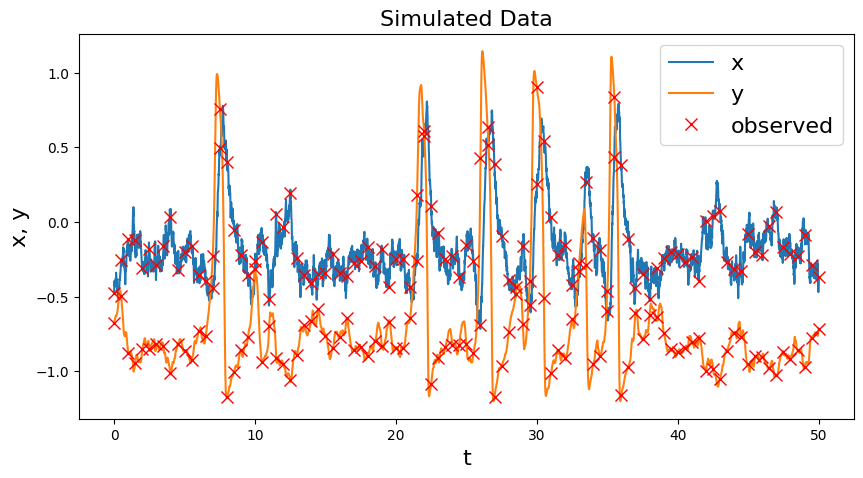

In [3]:
x_series, y_series = FNmodel.simulate(true_theta=true_theta, t_max=t_max, burn_out=burn_out, h=h)
t = jnp.linspace(0, t_max, len(x_series))
plt.figure(figsize=(10, 5))
plt.plot(t, x_series, label="x")
plt.plot(t, y_series, label="y")
plt.xlabel("t", fontsize=16)
plt.ylabel("x, y", fontsize=16)
plt.title("Simulated Data", fontsize=16)
# 5秒間隔で縦線をプロット
# 5秒間隔でグラフ上の点に大きなまるを表示
for i in range(0, len(t), 50):
    if i == 0:
        plt.plot(t[i], x_series[i], "x", color="red", markersize=8, label="observed")
        plt.plot(t[i], y_series[i], "x", color="red", markersize=8)
    else:
        plt.plot(t[i], x_series[i], "x", color="red", markersize=8)
        plt.plot(t[i], y_series[i], "x", color="red", markersize=8)
plt.legend(fontsize=16)
plt.show()

In [4]:
FN_likelihood = LikelihoodEvaluator(FNmodel)

In [5]:
v1 = FN_likelihood.make_quasi_likelihood_v1_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=3
)
v1_prime = FN_likelihood.make_quasi_likelihood_v1_prime_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=3
)
v2 = FN_likelihood.make_quasi_likelihood_v2_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=3
)
v3 = FN_likelihood.make_quasi_likelihood_v3_evaluator(
    x_series=x_series, y_series=y_series, h=h, k=3
)

In [6]:
def objective_func_1p(theta1_vec: jnp.ndarray) -> jnp.ndarray:
    return v1(theta1_vec, true_theta1, true_theta2, true_theta3)


def objective_func_1(theta1_vec: jnp.ndarray) -> jnp.ndarray:
    return v1(theta1_vec, true_theta1, true_theta2, true_theta3)


def objective_func_2(theta2_vec: jnp.ndarray) -> jnp.ndarray:
    return v2(theta2_vec, true_theta1, theta2_vec, true_theta3)


def objective_func_3(theta3_vec: jnp.ndarray) -> jnp.ndarray:
    return v3(theta3_vec, true_theta1, true_theta2, theta3_vec)


In [7]:
v3(jnp.array([0.1, 0.0]), true_theta1, true_theta2, jnp.array([0.1, 0.0]))  # -29.573065

Array(0.00979452, dtype=float32)

In [ ]:
est_1 = m_estimate(
    objective_function=objective_func_1, search_bounds=bounds_theta1, initial_guess=jnp.array([0.2])
)
print(est_1)
est_2 = m_estimate(
    objective_function=objective_func_2,
    search_bounds=bounds_theta2,
    initial_guess=jnp.array([0.5, 0.5]),
)
print(est_2)
est_3 = m_estimate(
    objective_function=objective_func_3,
    search_bounds=bounds_theta3,
    initial_guess=jnp.array([0.07, 0.9]),
)
print(est_3)

/Users/yanoshouta/simulation/degenerate_sim/estimation/parameter_estimator.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(bounds_list, dtype=jnp.float64)
/Users/yanoshouta/simulation/degenerate_sim/estimation/parameter_estimator.py:56: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  theta0 = jnp.asarray(initial_guess, dtype=jnp.float64)


[0.30490246]
[1.5070282 0.8773035]
[ 1.500000e-01 -8.986275e-05]


In [19]:
est

array([0.3046223], dtype=float32)

In [20]:
est = bayes_estimate(
    objective_function=objective_func,
    search_bounds=[(0.1, 0.5)],
    initial_guess=jnp.array([0.2]),
    num_warmup=500,
    num_samples=10000,
    num_chains=1,
    rng_seed=0,
)

/Users/yanoshouta/simulation/degenerate_sim/estimation/parameter_estimator.py:36: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return jnp.asarray(bounds_list, dtype=jnp.float64)
/Users/yanoshouta/simulation/degenerate_sim/estimation/parameter_estimator.py:133: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  theta0 = jnp.asarray(initial_guess, dtype=jnp.float64)
sample: 100%|██████████| 10500/10500 [10:41<00:00, 16.38it/s, 3 steps of size

In [22]:
print(est)

[0.33242214]


In [6]:
v1_prime_vect = vmap(v1_prime, (0, None, None, None), 0)
v1_vect = vmap(v1, (0, None, None, None), 0)
v2_vect = vmap(v2, (0, None, None, None), 0)
v3_vect = vmap(v3, (0, None, None, None), 0)

In [8]:
theta_1_list = jnp.linspace(0.1, 0.5, 100)
theta_1_list = theta_1_list.reshape(-1, 1)

In [9]:
theta_1_list[0]

Array([0.1], dtype=float32)

In [10]:
from jax import grad, vmap

In [11]:
v1_vect(theta_1_list, true_theta1, true_theta2, true_theta3)

Array([-6.9747243 , -6.3473496 , -5.7947235 , -5.306061  , -4.8724256 ,
       -4.486355  , -4.141659  , -3.8330243 , -3.5560274 , -3.306854  ,
       -3.08224   , -2.879387  , -2.69587   , -2.52958   , -2.3787048 ,
       -2.2416363 , -2.116971  , -2.0034723 , -1.9000641 , -1.8057861 ,
       -1.719773  , -1.6412746 , -1.5696054 , -1.504168  , -1.444414  ,
       -1.3898592 , -1.3400693 , -1.294643  , -1.2532278 , -1.2154994 ,
       -1.1811697 , -1.1499671 , -1.1216531 , -1.0960057 , -1.0728276 ,
       -1.0519321 , -1.0331521 , -1.0163367 , -1.0013411 , -0.98803896,
       -0.9763113 , -0.9660429 , -0.9571413 , -0.9495065 , -0.94305664,
       -0.93770915, -0.9333906 , -0.93003595, -0.9275792 , -0.9259625 ,
       -0.9251287 , -0.92503214, -0.92562264, -0.92685676, -0.92869043,
       -0.9310912 , -0.9340179 , -0.9374419 , -0.941331  , -0.9456573 ,
       -0.95038694, -0.95550275, -0.9609741 , -0.9667826 , -0.97291106,
       -0.97932976, -0.9860256 , -0.992986  , -1.0001894 , -1.00

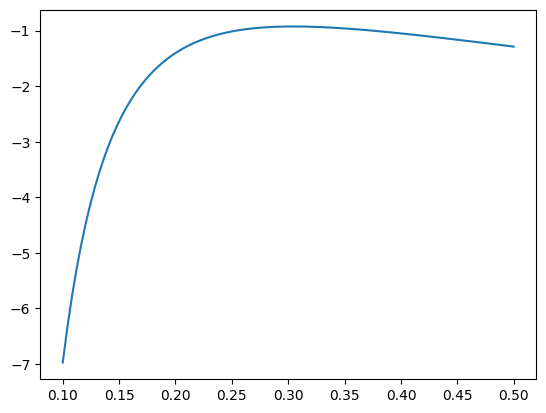

In [12]:
plt.plot(theta_1_list, v1_vect(theta_1_list, true_theta1, true_theta2, true_theta3))

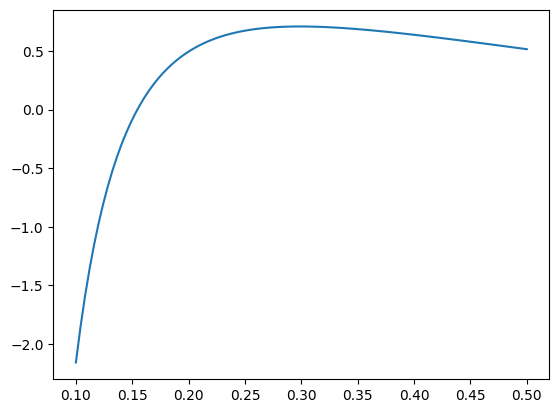

In [13]:
plt.plot(theta_1_list, v1_prime_vect(theta_1_list, true_theta1, true_theta2, true_theta3))

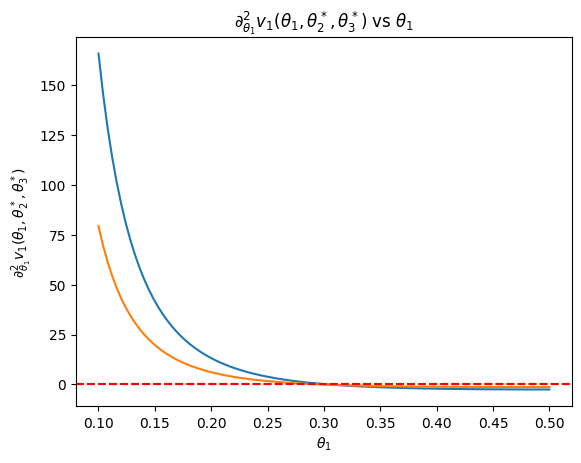

In [15]:
v1_grad = grad(v1, argnums=0)
v1_grad_vmap = vmap(v1_grad, (0, None, None, None), 0)
plt.plot(theta_1_list, v1_grad_vmap(theta_1_list, true_theta1, true_theta2, true_theta3))
plt.axhline(0, color="red", linestyle="--")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\partial_{\theta_1} v_1(\theta_1, \theta_2^*, \theta_3^*)$")
plt.title(r"$\partial_{\theta_1} v_1(\theta_1, \theta_2^*, \theta_3^*)$ vs $\theta_1$")
v1_prime_grad = grad(v1_prime, argnums=0)
v1_prime_grad_vmap = vmap(v1_prime_grad, (0, None, None, None), 0)
plt.plot(theta_1_list, v1_prime_grad_vmap(theta_1_list, true_theta1, true_theta2, true_theta3))
plt.axhline(0, color="red", linestyle="--")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\partial_{\theta_1}^2 v_1(\theta_1, \theta_2^*, \theta_3^*)$")
plt.title(r"$\partial_{\theta_1}^2 v_1(\theta_1, \theta_2^*, \theta_3^*)$ vs $\theta_1$")
plt.show()